In [ ]:
!pip install lifelines       # modelo convecional cox
!pip install pycox           # pycox (baseado em PyTorch)
!pip install scikit-survival # scikit-survival (integra com scikit-learn)
!pip install scipy==1.10.1
!pip install wfdb

#Exemplo 1

##Método convecional

<lifelines.CoxPHFitter: fitted with 100 total observations, 69 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 100
number of events observed = 31
   partial log-likelihood = -112.46
         time fit was run = 2025-04-15 13:09:50 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
qrs_duration  0.02      1.02      0.02           -0.02            0.06                0.98                1.06
heart_rate    0.01      1.01      0.02           -0.02            0.05                0.98                1.05
qt_interval  -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age          -0.02      0.98      0.01           -0.04            0.01                0.96                1.01
sex           0.47      1.61      0.39           -0.29            1.24                0.75                3.45

              cmp to     z    p  -log2(p)
covariate                                
qrs_duration    0.00  0.91 0.36      1.46
heart_rate      0.00  0.69 0.49      1.03
qt_interval     0.00 -0.45 0.65      0.62
age             0.00 -1.51 0.13      2.93
sex             0.00  1.21 0.22      2.16
---
Concordance = 0.58
Partial AIC = 234.91
log-likelihood ratio test = 4.46 on 5 df
-log2(p) of ll-ratio test = 1.04

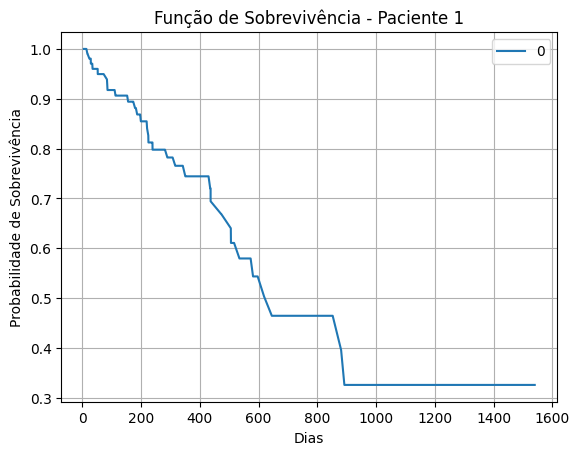

In [ ]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

# Simulando um dataset com 100 pacientes
np.random.seed(42)
n = 100

# Features extraídas do ECG (exemplo)
data = pd.DataFrame({
    'qrs_duration': np.random.normal(100, 10, n),        # duração do QRS em ms
    'heart_rate': np.random.normal(70, 10, n),           # frequência cardíaca
    'qt_interval': np.random.normal(400, 25, n),         # intervalo QT em ms
    'age': np.random.randint(30, 85, n),                 # idade do paciente
    'sex': np.random.choice([0, 1], size=n),             # 0 = mulher, 1 = homem
    'time': np.random.exponential(365, size=n),          # tempo até evento (dias)
    'event': np.random.binomial(1, 0.3, size=n)          # 1 = morte súbita, 0 = censurado
})

# Criando o modelo de Cox
cph = CoxPHFitter()
cph.fit(data, duration_col='time', event_col='event')

# Exibindo os resultados
cph.print_summary()

# Plotando a função de sobrevivência para um paciente específico
patient = data.iloc[0:1]
surv_func = cph.predict_survival_function(patient)
surv_func.plot(title="Função de Sobrevivência - Paciente 1")
plt.xlabel("Dias")
plt.ylabel("Probabilidade de Sobrevivência")
plt.grid()
plt.show()


#Exemplo 2

método 1 -CoxTime
#Modelo pytorch

O principal benefício que o Cox-Time (e os outros métodos de Cox) tem sobre o Logistic-Hazard é que ele é um método de tempo contínuo, o que significa que não precisamos discretizar a escala de tempo.

In [ ]:
# Bibliotecas básicas
import numpy as np                    # Biblioteca para operações numéricas
import matplotlib.pyplot as plt      # Para visualização de gráficos

# Pré-processamento de dados
from sklearn.preprocessing import StandardScaler          # Para normalização padronizada (média 0, desvio 1)
from sklearn_pandas import DataFrameMapper                # Para aplicar transformações do sklearn em dataframes

# Bibliotecas para Deep Learning com PyTorch
import torch                          # Biblioteca base para tensores e deep learning
import torchtuples as tt              # Abstração útil sobre PyTorch para modelos tabulares e de sobrevivência

# pycox: biblioteca especializada em modelos de sobrevivência com deep learning
from pycox.datasets import metabric                          # Dataset METABRIC (dados reais de câncer de mama)
from pycox.models import CoxTime                             # Implementação do modelo CoxTime (risco não proporcional)
from pycox.models.cox_time import MLPVanillaCoxTime          # Arquitetura de rede neural padrão usada pelo CoxTime
from pycox.evaluation import EvalSurv                        # Classe para avaliar desempenho de modelos de sobrevivência


In [ ]:
## Uncomment to install `sklearn-pandas`
#! pip install sklearn-pandas

In [ ]:
np.random.seed(1234)
_ = torch.manual_seed(123)

##Conjunto de dados
Carregamos o conjunto de dados METABRIC e dividimos em treinamento, teste e validação.

In [ ]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

Dataset 'metabric' not locally available. Downloading...
Done


In [ ]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1218 entries, 0 to 1903
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x0        1218 non-null   float32
 1   x1        1218 non-null   float32
 2   x2        1218 non-null   float32
 3   x3        1218 non-null   float32
 4   x4        1218 non-null   float32
 5   x5        1218 non-null   float32
 6   x6        1218 non-null   float32
 7   x7        1218 non-null   float32
 8   x8        1218 non-null   float32
 9   duration  1218 non-null   float32
 10  event     1218 non-null   int32  
dtypes: float32(10), int32(1)
memory usage: 61.9 KB


##Transformações de recursos
Temos 9 covariáveis, além das durações e indicadores de eventos.

- Padronizaremos as 5 covariáveis ​​numéricas e deixaremos as variáveis ​​binárias como estão. As variáveis ​​precisam ser do tipo 'float32', conforme exigido pelo PyTorch.

In [ ]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

- Os alvos (durações e eventos) também precisam ser matrizes do tipo 'float32', e com isso CoxTime.label_transformpadronizamos as durações.

In [ ]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [ ]:
val.shapes()

((305, 9), ((305,), (305,)))

- Com TupleTree(os resultados de tt.tuplefy), podemos facilmente repetir o conjunto de dados de validação várias vezes. Isso será útil para reduzir a variância da perda de validação, já que a perda de validação de CoxTimenão é determinística.

In [ ]:
val.repeat(2).cat().shapes()

((610, 9), ((610,), (610,)))

##Rede neural
- Criamos um MLP simples com duas camadas ocultas: ativações ReLU, norma de lote e dropout. A rede necessária por CoxTime ligeiramente diferente da maioria dos outros métodos, pois também recebe time um argumento de entrada adicional. Portanto, criamos a MLPVanillaCoxTime classe que é uma versão adequada de tt.practical.MLPVanilla. Esta classe também remove as opções para definir out_features output_bias como deveriam ser 1 e False, respectivamente.

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

##Treinando o modelo

- Para treinar o modelo, precisamos definir um otimizador. Você pode escolher qualquer torch.optimotimizador, mas aqui usamos um de , tt.optimpois ele tem algumas funcionalidades adicionais. Usamos o Adamotimizador, mas em vez de escolher uma taxa de aprendizado, usaremos o esquema proposto por [Smith em 2017](https://arxiv.org/pdf/1506.01186) para encontrar uma taxa de aprendizado adequada com model.lr_finder. Veja esta [publicação](https://pytorch-lightning.readthedocs.io/en/1.5.10/advanced/lr_finder.html) para uma explicação.

- Também definimos labtrans a conexão entre os nós de saída da rede e a transformação de rótulo das durações. Isso é útil apenas para previsão e não afeta o procedimento de treinamento.


In [ ]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)

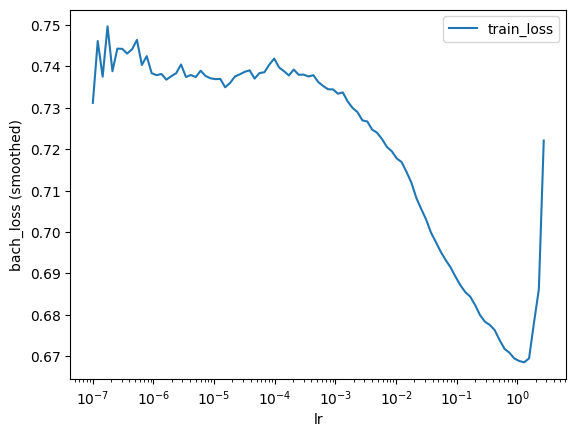

In [ ]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [ ]:
lrfinder.get_best_lr()

0.12915496650148922

Muitas vezes, essa taxa de aprendizagem é um pouco alta, então a definimos manualmente para 0,01

In [ ]:
model.optimizer.set_lr(0.01)

Incluímos o EarlyStopping retorno de chamada para interromper o treinamento quando a perda de validação parar de melhorar. Após o treinamento, esse retorno de chamada também carregará o modelo com melhor desempenho em termos de perda de validação.

In [ ]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [ ]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.6871,	val_loss: 0.6503
1:	[0s / 0s],		train_loss: 0.6733,	val_loss: 0.6368
2:	[0s / 0s],		train_loss: 0.6223,	val_loss: 0.6150
3:	[0s / 0s],		train_loss: 0.6250,	val_loss: 0.6263
4:	[0s / 0s],		train_loss: 0.6060,	val_loss: 0.6090
5:	[0s / 0s],		train_loss: 0.6079,	val_loss: 0.6055
6:	[0s / 0s],		train_loss: 0.5984,	val_loss: 0.5997
7:	[0s / 0s],		train_loss: 0.5951,	val_loss: 0.5976
8:	[0s / 0s],		train_loss: 0.5813,	val_loss: 0.5956
9:	[0s / 0s],		train_loss: 0.6006,	val_loss: 0.5804
10:	[0s / 0s],		train_loss: 0.5962,	val_loss: 0.5880
11:	[0s / 0s],		train_loss: 0.5750,	val_loss: 0.5951
12:	[0s / 0s],		train_loss: 0.5829,	val_loss: 0.5949
13:	[0s / 0s],		train_loss: 0.5725,	val_loss: 0.5845
14:	[0s / 0s],		train_loss: 0.5759,	val_loss: 0.5938
15:	[0s / 0s],		train_loss: 0.5698,	val_loss: 0.5752
16:	[0s / 0s],		train_loss: 0.5656,	val_loss: 0.5893
17:	[0s / 0s],		train_loss: 0.5802,	val_loss: 0.5915
18:	[0s / 0s],		train_loss: 0.5791,	val_loss: 0.5974
19:

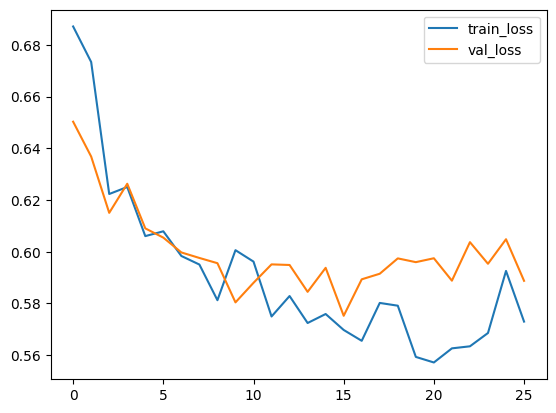

In [ ]:
_ = log.plot()

Podemos obter o logaritmo parcial da verossimilhança

We can get the partial log-likelihood

In [ ]:
model.partial_log_likelihood(*val).mean()

-4.859583

##Previsão

- Para avaliação, precisamos primeiro obter estimativas de sobrevivência para o conjunto de teste. Isso pode ser feito com model.predict_surv which retorna um array de estimativas de sobrevivência ou com model.predict_surv_df which retorna as estimativas de sobrevivência como um dataframe.

- Entretanto, como o tempo de Cox é semiparamétrico, primeiro precisamos obter as estimativas de risco de base não paramétricas com compute_baseline_hazards.

- Observe que, para grandes conjuntos de dados, o sample argumento pode ser usado para estimar o risco de base em um subconjunto.

In [ ]:
_ = model.compute_baseline_hazards()

In [ ]:
surv = model.predict_surv_df(x_test)

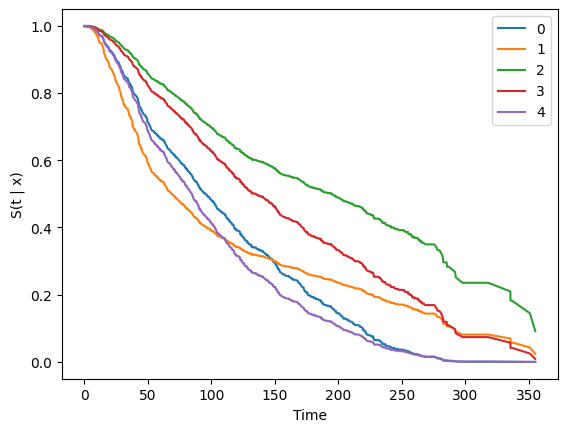

In [ ]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

Observe que, como definimos labtrans, CoxTimeobtemos a escala de tempo correta para nossas previsões.

##Avaliação
- Podemos usar a EvalSurvclasse para avaliar a concordância, o escore de Brier e a verossimilhança logarítmica binomial. A configuração censor_surv='km'significa que estimamos a distribuição de censura de Kaplan-Meier no conjunto de teste.

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [ ]:
ev.concordance_td()

0.6657696219698254

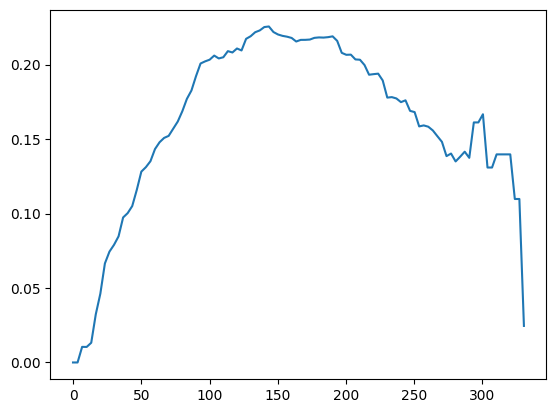

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [ ]:
ev.integrated_brier_score(time_grid)

0.16221951186135378

In [ ]:
ev.integrated_nbll(time_grid)

0.478398388288698